In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *

In [7]:
#!mkdir -p ~/.kaggle/
#!mv kaggle.json ~/.kaggle/

In [3]:
path = Config.data_path()/'humpback'
path.mkdir(parents=True,exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/humpback')

In [20]:
#!kaggle competitions download -c humpback-whale-identification -f train.zip -p {path}
#!kaggle competitions download -c humpback-whale-identification -f train.csv -p {path}
#!kaggle competitions download -c humpback-whale-identification -f test.zip -p {path}
#!kaggle competitions download -c humpback-whale-identification -f sample_submission.csv -p {path}

  0%|                                                | 0.00/498k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 498k/498k [00:00<00:00, 116MB/s]


In [28]:
#!unzip -q -n {path}/test.zip -d {path}/test

In [33]:
#!ls {path}

test  test.zip	train  train.csv  train.zip


In [26]:
#!mkdir -p /home/jupyter/.fastai/data/humpback/test

##Finished setup data##

In [4]:
df_label = pd.read_csv(f'{path}/train.csv')
df_label.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [5]:
#split validation set
#if train set has at least 3 or more images for a specific class, take 1 to valid
df_test_split = df_label.copy()
df_grouped = df_test_split.groupby('Id').apply(lambda x: x.sample(frac=0.2,random_state=47))
df_grouped.tail()

Image         Id
Id                                      
w_fec331a 7478  4bd09e7eb.jpg  w_fec331a
          3967  2898bb378.jpg  w_fec331a
w_fec5547 1580  0fd6ca5c6.jpg  w_fec5547
w_ff2157c 3480  23cae24e7.jpg  w_ff2157c
w_ffa542b 7899  4f9e431aa.jpg  w_ffa542b

In [6]:
df_merged = pd.merge(left=df_test_split,right=df_grouped,on='Image',how='left',suffixes=('','_y'))
df_merged.head(20)

,Image,Id,Id_y
0,0000e88ab.jpg,w_f48451c,NaN
1,0001f9222.jpg,w_c3d896a,w_c3d896a
2,00029d126.jpg,w_20df2c5,w_20df2c5
3,00050a15a.jpg,new_whale,NaN
4,0005c1ef8.jpg,new_whale,NaN
5,0006e997e.jpg,new_whale,NaN
6,000a6daec.jpg,w_dd88965,NaN
7,000f0f2bf.jpg,new_whale,NaN
8,0016b897a.jpg,w_64404ac,NaN
9,001c1ac5f.jpg,w_a6f9d33,NaN


In [7]:
df_merged['is_valid'] = df_merged.Id_y.isnull()!=True
df_merged.head()

,Image,Id,Id_y,is_valid
0,0000e88ab.jpg,w_f48451c,NaN,False
1,0001f9222.jpg,w_c3d896a,w_c3d896a,True
2,00029d126.jpg,w_20df2c5,w_20df2c5,True
3,00050a15a.jpg,new_whale,NaN,False
4,0005c1ef8.jpg,new_whale,NaN,False


In [8]:
df_merged.drop('Id_y',axis=1,inplace=True)
df_merged.head()

,Image,Id,is_valid
0,0000e88ab.jpg,w_f48451c,False
1,0001f9222.jpg,w_c3d896a,True
2,00029d126.jpg,w_20df2c5,True
3,00050a15a.jpg,new_whale,False
4,0005c1ef8.jpg,new_whale,False


In [9]:
df_merged.to_csv(f'{path}/validation_random.csv',index=False)

In [10]:
#create databunch,prepare for training
src = (ImageItemList.from_csv(f'{path}/',f'{path}/validation_random.csv',folder='train')
      .split_from_df(col='is_valid')
      .label_from_df(cols='Id'))

In [11]:
data = (src.transform(get_transforms(max_zoom=1, max_warp=0, max_rotate=2),resize_method=ResizeMethod.SQUISH,size=224)
       .add_test_folder('test')
       .databunch()
       .normalize(imagenet_stats))

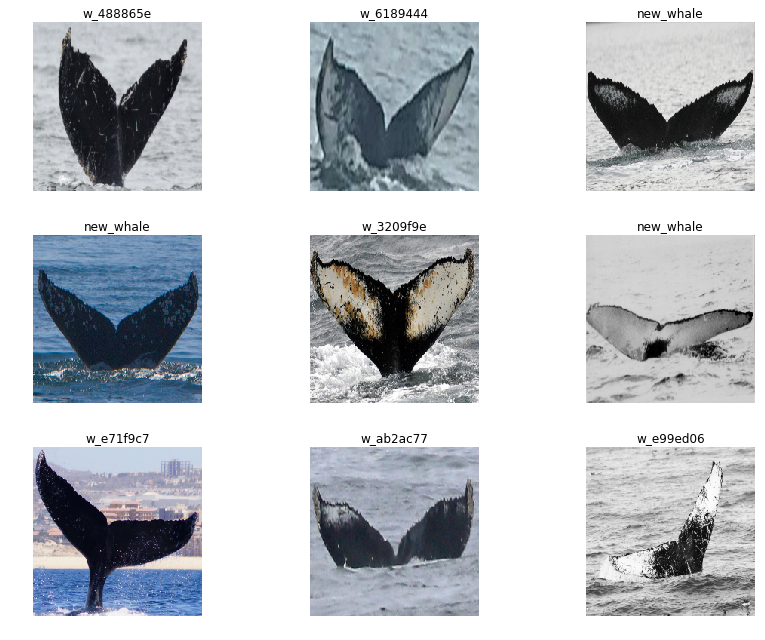

In [12]:
data.show_batch(rows=3,figsize=(12,9))

In [13]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def map5(preds, targs):
    predicted_idxs = preds.sort(descending=True)[1]
    top_5 = predicted_idxs[:, :5]
    res = mapk([[t] for t in targs.cpu().numpy()], top_5.cpu().numpy(), 5)
    return torch.tensor(res)

In [18]:
learn = create_cnn(data,models.resnet34,metrics = [accuracy,map5])

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


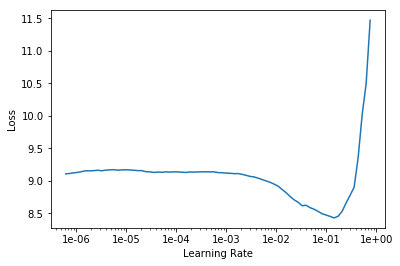

In [53]:
learn.recorder.plot()

In [14]:
lr = 0.1/2

In [56]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy
1,6.636756,5.033126,0.439736
2,6.352223,5.515798,0.436090
3,5.853189,4.506191,0.443381
4,5.364259,4.243982,0.456824
5,4.719284,3.680866,0.469127


In [26]:
learn.save(f'{path}-stage-1-rn34')

In [24]:
learn.load(f'{path}-stage-1-rn34')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (20972 items)
[Category w_f48451c, Category new_whale, Category new_whale, Category new_whale, Category w_dd88965]...
Path: /home/jupyter/.fastai/data/humpback
x: ImageItemList (20972 items)
[Image (3, 700, 1050), Image (3, 525, 1050), Image (3, 525, 1050), Image (3, 276, 980), Image (3, 458, 1050)]...
Path: /home/jupyter/.fastai/data/humpback;

Valid: LabelList
y: CategoryList (4389 items)
[Category w_c3d896a, Category w_20df2c5, Category new_whale, Category new_whale, Category new_whale]...
Path: /home/jupyter/.fastai/data/humpback
x: ImageItemList (4389 items)
[Image (3, 325, 758), Image (3, 497, 1050), Image (3, 600, 1050), Image (3, 492, 1050), Image (3, 500, 700)]...
Path: /home/jupyter/.fastai/data/humpback;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [19]:
learn.fit_one_cycle(2,slice(lr))

epoch,train_loss,valid_loss,accuracy,map5
1,6.821884,5.155326,0.434040,0.437643
2,5.807021,4.721110,0.440191,0.450729


In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


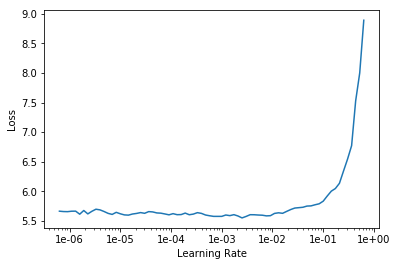

In [22]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(5,slice(1e-4/2,lr/2)) #1e-03/2, 1e-02/2

epoch,train_loss,valid_loss,accuracy,map5
1,5.913209,3819.830322,0.345637,0.348884
2,6.052186,8.963194,0.425382,0.436079
3,5.718854,4.979062,0.443153,0.459919
4,5.267720,18.744467,0.450672,0.479130
5,4.893553,11.504254,0.454773,0.488536


In [14]:
learn_res_50 = create_cnn(data,models.resnet50,metrics = [accuracy,map5])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


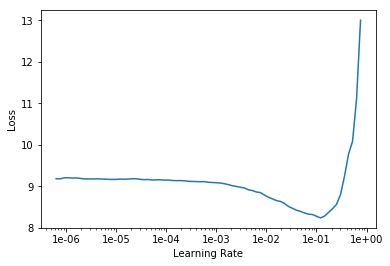

In [16]:
learn_res_50.lr_find()
learn_res_50.recorder.plot()

In [18]:
lr = 1e-2

In [18]:
learn_res_50.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,map5
1,6.110111,4.551921,0.439964,0.465478
2,5.513465,4.056387,0.463659,0.503372
3,4.775876,3.295666,0.499658,0.556292
4,4.050110,2.881838,0.545910,0.607306
5,3.312176,2.765129,0.557302,0.619131


In [19]:
learn_res_50.save(f'{path}-stage-1-res50-224')

In [15]:
learn_res_50.load(f'{path}-stage-1-res50-224')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (20972 items)
[Category w_f48451c, Category new_whale, Category new_whale, Category new_whale, Category w_dd88965]...
Path: /home/jupyter/.fastai/data/humpback
x: ImageItemList (20972 items)
[Image (3, 700, 1050), Image (3, 525, 1050), Image (3, 525, 1050), Image (3, 276, 980), Image (3, 458, 1050)]...
Path: /home/jupyter/.fastai/data/humpback;

Valid: LabelList
y: CategoryList (4389 items)
[Category w_c3d896a, Category w_20df2c5, Category new_whale, Category new_whale, Category new_whale]...
Path: /home/jupyter/.fastai/data/humpback
x: ImageItemList (4389 items)
[Image (3, 325, 758), Image (3, 497, 1050), Image (3, 600, 1050), Image (3, 492, 1050), Image (3, 500, 700)]...
Path: /home/jupyter/.fastai/data/humpback;

Test: LabelList
y: EmptyLabelList (7960 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7960 items)
[Image (3, 220, 602), Image (3, 806, 1050), Image (3, 584

In [16]:
learn_res_50.unfreeze()

In [22]:
learn_res_50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


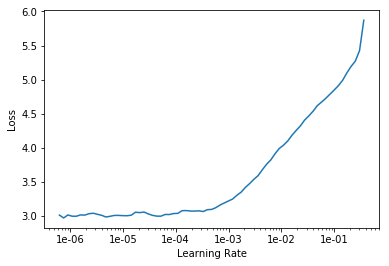

In [23]:
learn_res_50.recorder.plot()

In [38]:
learn_res_50.fit_one_cycle(3,slice(1e-5/2,lr/5))

epoch,train_loss,valid_loss,accuracy,map5
1,1.926616,2.497177,0.611529,0.675207
2,1.778278,2.233463,0.635908,0.698899
3,0.964395,2.154706,0.650946,0.712824


In [43]:
learn_res_50.save(f'{path}-stage-2-res50-224')

# Fin

In [39]:
preds,_ = learn_res_50.get_preds(DatasetType.Test)

In [33]:
#!mkdir -p subs

In [32]:
def top_5_preds(preds): return np.argsort(preds.numpy())[:, ::-1][:, :5]

def top_5_pred_labels(preds, classes):
    top_5 = top_5_preds(preds)
    labels = []
    for i in range(top_5.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top_5[i]]))
    return labels

def create_submission(preds, data, name, classes=None):
    if not classes: classes = data.classes
    sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub['Id'] = top_5_pred_labels(preds, classes)
    sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [40]:
create_submission(preds, learn_res_50.data, 'res50-224-0.7128')

In [41]:
pd.read_csv(f'subs/res50-224-0.7128.csv.gz').head()

,Image,Id
0,8fe153df5.jpg,new_whale w_ae19ff0 w_70d0b3c w_5946cd1 w_e145c7a
1,a0f38fccb.jpg,new_whale w_5773c71 w_d405854 w_ab2ac77 w_00f340d
2,65a1c41f2.jpg,new_whale w_39141fc w_8e92662 w_9f13096 w_80acb6f
3,acc799677.jpg,new_whale w_bef0a5d w_e4a9205 w_877de07 w_23ce00e
4,7ed205c6c.jpg,w_bf2b915 w_d573a68 w_dea40e2 w_2f67f0a w_9b5109b


In [42]:
!kaggle competitions submit -c humpback-whale-identification -f subs/res50-224-0.7128.csv.gz -m "res50-224-0.7128"

100%|█████████████████████████████████████████| 166k/166k [00:01<00:00, 136kB/s]
Successfully submitted to Humpback Whale Identification